In [1]:
pip install psi4

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement psi4 (from versions: none)
ERROR: No matching distribution found for psi4
Note: you may need to restart the kernel to use updated packages.


Part1

1. Basic Input Structure

In [2]:
# This is the important part
import psi4

In [3]:
%%time
psi4.set_output_file('output.dat', False)

CPU times: user 136 µs, sys: 1.72 ms, total: 1.85 ms
Wall time: 5.18 ms


PosixPath('output.dat')

2. Running a Basic Hartree-Fock Calculation

In [4]:
%%time
#! Sample HF/cc-pVDZ H2O Computation

psi4.set_memory('500 MB')

h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

psi4.energy('scf/cc-pvdz')

CPU times: user 400 ms, sys: 111 ms, total: 511 ms
Wall time: 2.07 s


-76.0266327350902

In [5]:
%%time
#! Sample UHF/6-31G** CH2 Computation

R = 1.075
A = 133.93

ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A)
)

psi4.set_options({'reference': 'uhf'})
psi4.energy('scf/6-31g**')

CPU times: user 300 ms, sys: 12.9 ms, total: 313 ms
Wall time: 393 ms


-38.92533462893707

3. Geometry Optimization and Vibrational Frequency Analysis

In [7]:
%%time
psi4.set_options({'reference': 'rhf'})
psi4.optimize('scf/cc-pvdz', molecule=h2o)

Optimizer: Optimization complete!
CPU times: user 369 ms, sys: 26.4 ms, total: 395 ms
Wall time: 409 ms


-76.0270327293759

4. Analysis of Intermolecular Interaction


In [8]:
%%time
# Example SAPT computation for ethene*ethyne (*i.e.*, ethylene*acetylene).
# Test case 16 from S22 Database

dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")
psi4.set_options({'scf_type': 'df',
                  'freeze_core': True})

psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)

CPU times: user 4.23 s, sys: 416 ms, total: 4.64 s
Wall time: 4.82 s


-0.0022355823909805178

5. Potential Surface Scans and Counterpoise Correction Made Easy

In [11]:
%%time
#! Example potential energy surface scan and CP-correction for Ne2

ne2_geometry = """
Ne
--
Ne 1 {0}
"""

Rvals = [2.5, 3.0, 4.0]

psi4.set_options({'freeze_core': True})

# Initialize a blank dictionary of counterpoise corrected energies
# (Need this for the syntax below to work)

ecp = {}

for R in Rvals:
    ne2 = psi4.geometry(ne2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ne2)

# Prints to screen
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

# Prints to output.dat
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))


CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies


          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            2.5                        0.758605
            3.0                        0.015968
            4.0                        -0.016215
CPU times: user 5.76 s, sys: 1.64 s, total: 7.4 s
Wall time: 8.12 s


Part2

computed the energy of Neon at several different distances.

In [ ]:
import numpy as np

def lj(r, sigma, eps):
    return 4 * eps * ((sigma/r)**12 - (sigma/r)**6)

distances = np.linspace(3.5, 6.0, num=20)
energies = []

psi4.set_options({'freeze_core': True})
for d in distances:
    mol = psi4.geometry(f"""
    Ar
    --
    Ar 1 {d}
    """)

    # psi4.optimize('B3LYP', molecule=mol)
    energy = psi4.energy("ccsd(t)/aug-cc-pvdz", bsse_type='cp', molecule=mol)
    energies.append(energy)
from scipy.optimize import curve_fit
params, params_covariance = curve_fit(lj, distances, energies, p0=[3.8, 0.2])

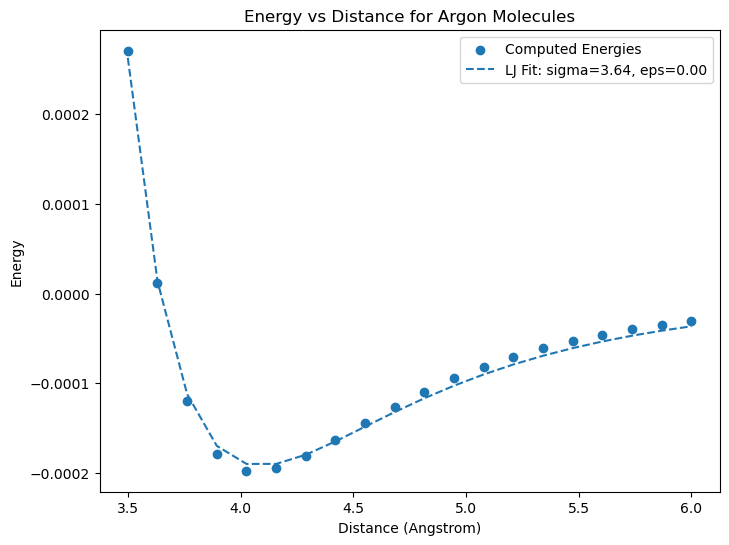

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(distances, energies, label='Computed Energies')
plt.plot(distances, lj(distances, *params), linestyle='dashed', label='LJ Fit: sigma=%.2f, eps=%.2f' % tuple(params))
plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy vs Distance for Argon Molecules')

plt.savefig('Figures/argon_energy_curve.png')
plt.show()